In [1]:
from __future__ import print_function
import pdb, math
import matplotlib.pyplot as plt
import numpy as np
import torch
import pdb
import torch.nn as nn
plt.rcParams["figure.figsize"] = (12,12)

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
class SDF(nn.Module):
    def __init__(self):
        super(SDF, self).__init__()
        self.fc1 = nn.Linear(515, 512)
        self.drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 512)     
        self.fc6 = nn.Linear(512, 1)
        
    def forward(self, x):
#         pdb.set_trace()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [4]:
import numpy as np
import os
# coords = np.load('coords.npy')
# SDFs = np.load('SDF.npy')

coords = [np.load(f'/home/alex/data/3dc_images/sdf/{x}_coords.npy') for x in range(100)]
SDFs = [np.load(f'/home/alex/data/3dc_images/sdf/{x}_SDF.npy') for x in range(100)]

idxes = []
for i, c in enumerate(coords):
    for x in range(c.shape[0]):
        idxes.append(i)
        
coords = np.concatenate(coords)
SDFs = np.concatenate(SDFs)

# idxes 

In [31]:
image = np.load(f'/home/alex/data/3dc_images/images/3_image.npy')
# image = torch.tensor(image)

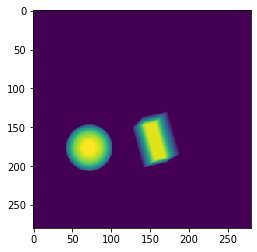

In [32]:
plt.imshow(image)

In [17]:
from torch.utils.data import Dataset, DataLoader

class SDFDataset(Dataset):

    def __init__(self,coords,SDFs):
       
        self.coords = coords
        self.SDFs = SDFs

    def __len__(self):
        return len(self.SDFs)

    def __getitem__(self, idx):
#         print(idx)
        coord = torch.from_numpy(self.coords[idx])
        sdf = torch.from_numpy(np.array(self.SDFs[idx])).unsqueeze(0)
        
        image = np.load(f'/home/alex/data/3dc_images/images/{idxes[idx]}_image.npy')
        image = torch.tensor(image)
        
        image = image.unsqueeze(2).repeat(1,1,3).permute(2,0,1)/255-.5
        
        sample = {'coords': coord, 'sdf': sdf, 'image': image}

        return sample

In [18]:
import random
from torch.utils import data
dataset = SDFDataset(coords,SDFs)

idx = list(range(len(coords)))
random.shuffle(idx)  # in-place shuffle the indices to facilitate random splitting
train_idx = idx[:int(len(coords)*0.8)]
test_idx = idx[int(len(coords)*0.8):]

train_set = data.Subset(dataset, train_idx)
test_set = data.Subset(dataset, test_idx)

train_dataloader = DataLoader(train_set, batch_size=64, num_workers=4, 
                              sampler=torch.utils.data.RandomSampler(train_set, replacement=True, num_samples=100000))
test_dataloader = DataLoader(test_set, batch_size=64, num_workers=4,
                            sampler=torch.utils.data.RandomSampler(test_set, replacement=True, num_samples=10000))

In [19]:
from torchvision import datasets, models, transforms

resnet18 = models.resnet18(pretrained=True)
modules = list(resnet18.children())[:-1]
resnet18 = nn.Sequential(*modules).to('cuda')

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    resnet18.train()
    for batch_idx, sample in enumerate(train_loader):
        optimizer.zero_grad()
        data, target, image = sample['coords'].to(device), sample['sdf'].to(device), sample['image'].to(device)
        
        vectors = resnet18(image)[:,:,0,0]
#         pdb.set_trace()
        output = model(torch.cat([data,vectors], dim=1))
        
        loss = F.l1_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader, optimizer, epoch, best_loss=1):
    model.eval()
    resnet18.eval()
    losses = []
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target, image = sample['coords'].to(device), sample['sdf'].to(device), sample['image'].to(device)
            vectors = resnet18(image).view(-1,512)
            output = model(torch.cat([data,vectors], dim=1))
            loss = F.l1_loss(output, target)
            losses.append(loss)
    #     pdb.set_trace()
        loss = sum(losses)/len(losses)
        print(f'test loss:{loss}')
        if loss<best_loss:
            torch.save(model.state_dict(), f'model/sdf_with_latent_e2e_ft{epoch}.torch')
#             pdb.set_trace()
            torch.save(resnet18.state_dict(), f'model/resnet_latent_ft1{epoch}.torch')
            best_loss = loss
        return best_loss

In [20]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = SDF().to(device)

In [33]:
optimizer = optim.Adam(list(model.parameters())+list(resnet18.parameters()), lr=1e-4)
best_loss = 10

# resnet18.load_state_dict(torch.load('resnet_latent.torch'))

# model.load_state_dict(torch.load('sdf_with_latent_e2e.torch'))
        
for epoch in range(1, 50 + 1):

    train(model, device, train_dataloader, optimizer, epoch)
    best_loss = test(model, device, test_dataloader, optimizer, epoch, best_loss)

Train Epoch: 1 [0/5732532 (0%)]	Loss: 0.108007
Train Epoch: 1 [640/5732532 (6%)]	Loss: 0.112971


KeyboardInterrupt: 

In [35]:
!jupyter nbconvert --to script 7.8-final_train.ipynb

[NbConvertApp] Converting notebook 7.8-final_train.ipynb to script
[NbConvertApp] Writing 5650 bytes to 7.8-final_train.py
